# Exploring EPICA Dome C records with Pyleoclim

In this demo, we set out to explore the mystery of Ice Ages as documented from the EPICA Dome C ice core. The Deuterium data $\delta D$  was published by [Jouzel et al. (2007)](https://doi.org/10.1126/science.1141038). It is a proxy for the temperature of snow formation above the site, taken to be representive of Antartic temperature over such timescales.
 
The demo also makes use of $CO_2$ measurements came from [Luthi et al (2008)](https://www.nature.com/articles/nature06949), corrected by [Bereiter et al. (2015)](http://onlinelibrary.wiley.com/doi/10.1002/2014GL061957/abstract).

In [45]:
# Load necessary packages first
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyleoclim as pyleo
pyleo.set_style('web')

Load and plot the $\delta D$ series

In [2]:
#name = 'https://www.ncei.noaa.gov/pub/data/paleo/icecore/antarctica/epica_domec/edc3deuttemp2007.txt'
#dDdf = pd.read_csv(name,skiprows=91,encoding= 'unicode_escape',sep='\t') # still struggling to load properly
#dDdf.head()

In [3]:
dDdf = pd.read_csv('../data/edc3deuttemp2007.csv',encoding= 'unicode_escape')
dDdf.head()

,Age,Deuterium,Temperature
0,38.37379,-390.9,0.88
1,46.81203,-385.1,1.84
2,55.05624,-377.8,3.04
3,64.41511,-394.1,0.35
4,73.15077,-398.7,-0.42


Part of using any software package is that you need to give it the data in the format it wants them. In this case we leverage a data structure called `Series` (more info [here](https://pyleoclim-util.readthedocs.io/en/master/core/ui.html#series-pyleoclim-series)), which is easy to do once we load the data with pandas:

In [4]:
dDts = pyleo.Series(time=dDdf['Age']/1000,value= dDdf['Deuterium'],time_name='Age',time_unit='kyr BP',value_name = r'$\delta D$',value_unit=u'\u2030',label=r'EPICA Dome C $\delta D$')

We can plot this with a single line of code, which greatly simplifies life:

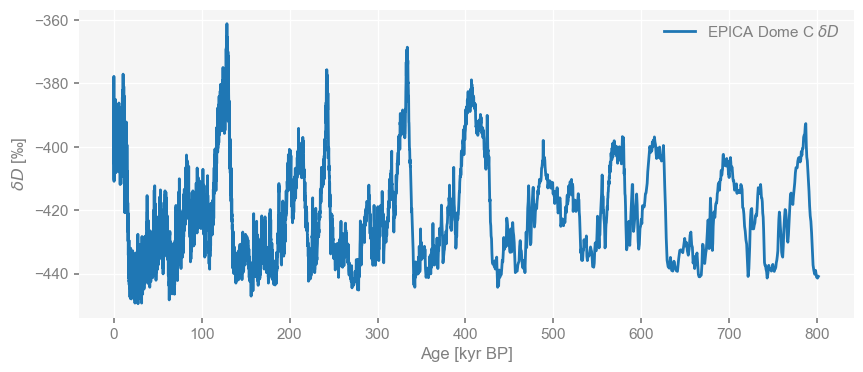

(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot:xlabel='Age [kyr BP]', ylabel='$\\delta D$ [‰]'>)

In [5]:
dDts.plot()

Notice how we put in quite a bit of metadata (information about the data) when we created the Series object, and that this information is now being used by the code to properly label axes for you. Structuring and labeling your data is a little more work upfront but it pays big dividends down the line. Let's see that now.

First, take a look at the distribution of time increments: 

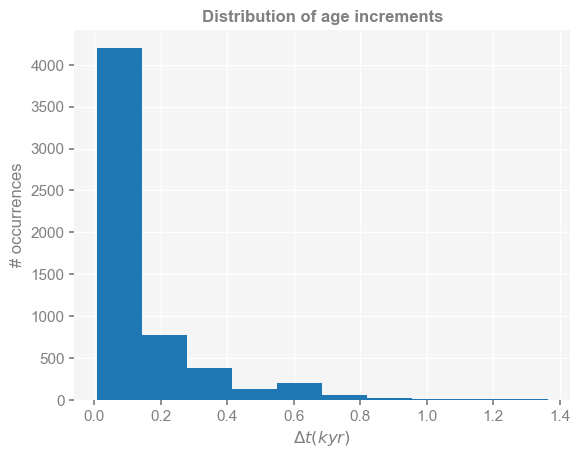

In [6]:
fig, ax = plt.subplots()
plt.hist(np.diff(dDts.time))
plt.xlabel(r'$\Delta t (kyr)$')
plt.ylabel('# occurrences')
plt.title('Distribution of age increments',weight='bold')
pyleo.showfig(fig)

The data are not evenly spaced, which is a challenge for spectral analysis because most timeseries analysis methods (e.g. Fourier analysis) make the implicit assumption that data are evenly spaced, so applying those tools to unevenly-spaced data will result in methods not behaving as they are supposed to.

 ## Spectral Analysis
 
 Thankfully, Pyleoclim can deal with that challenge very easily. Using two methods:
 - Lomb-Scargle periodogram
 - Weighted-Wavelet Z-transform
 
 The former is fast, but far from optimal. WWZ is usually better, but can be very slow for large datasets.

### Lomb-Scargle Periodogram

We start with the [Lomb-Scargle periodogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lombscargle.html), which may be accessed via the `spectral` method associated with any `Series` object:

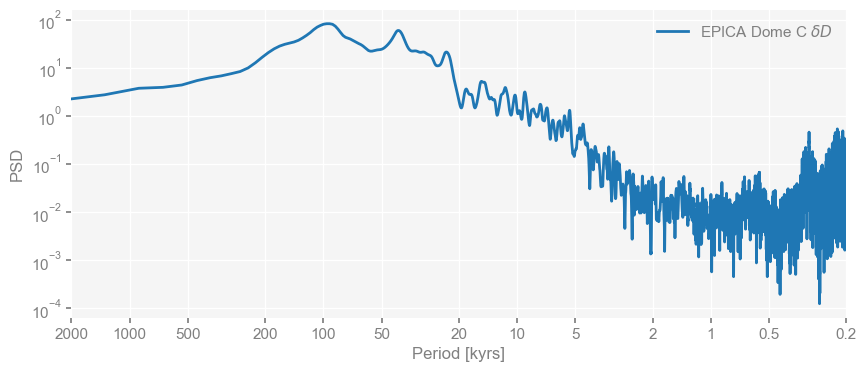

(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot:xlabel='Period [kyrs]', ylabel='PSD'>)

In [7]:
psd_ls = dDts.standardize().spectral(method='lomb_scargle', freq_method='lomb_scargle')
psd_ls.plot()

Notice how we chained together threed commands to do this: we first standardized the data (not strictly necessary, but useful later), computed the spectrum, stored this output in a variable (we'll see why in a minute), then plotted it. Notice also how the plot contains all the labels you would want, and the frequency axis is labeled in terms of periods, which are much more intuitive than their inverse (periods).  

Which of these peaks are significant? To do so, the method `signif_test` allows you to do what we did in part 2 with one line of code. Notice how we apply to `psd_ls`, the structure that stored the result from the LS method:

Performing spectral analysis on individual series: 100%|█████████████████████████████████████████████████████████████████| 200/200 [14:34<00:00,  4.37s/it]


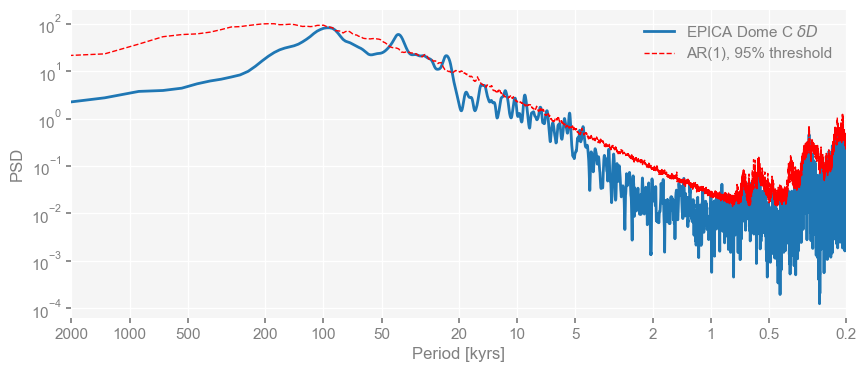

(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot:xlabel='Period [kyrs]', ylabel='PSD'>)

In [8]:
psd_ls_signif = psd_ls.signif_test(number=200) # simulate AR(1) benchmarks
psd_ls_signif.plot()

We see that the orbital periods poke above the 95% threshold, but not by much. Certainly, none of the high-frequency wiggles are. It would make more sense to interpolate the data at 0.5ky resolution and redo this. In fact, you can do this all in a single line of code:

Performing spectral analysis on individual series: 100%|█████████████████████████████████████████████████████████████████| 200/200 [00:57<00:00,  3.46it/s]


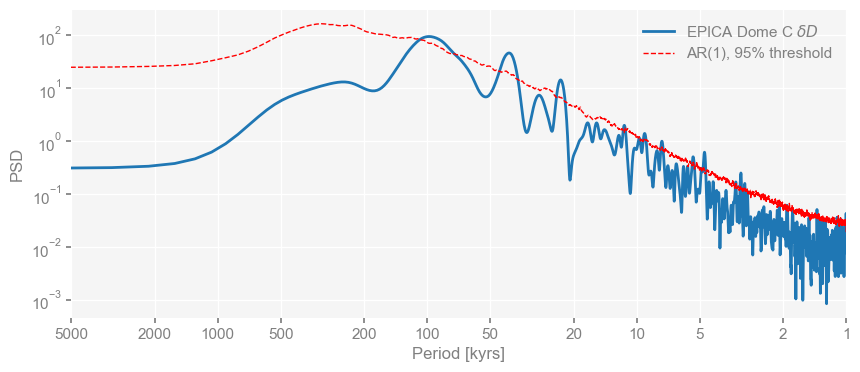

(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot:xlabel='Period [kyrs]', ylabel='PSD'>)

In [9]:
dDts.interp(step=0.5).standardize().spectral(method='lomb_scargle',freq_method='lomb_scargle').signif_test(number=200).plot()

The result is still a bit noisy, but at least we've cut all that high-frequency junk, and because the timeseries are shorter, the computations are much faster. Now, let's see what the Weighted Wavelet Z-transform makes of the same data.  We can see peaks poking above the AR(1) significance level at the classical orbital periodicities: 21 ky (precession), 41 ky (obliquity) and 100 ky (eccentricity), with a number of higher frequency peaks breaching that limit as well.  


Now let's apply the same worlflow (interpolation, then standardization) with the Weighted Wavelet Z-tranform (WWZ):

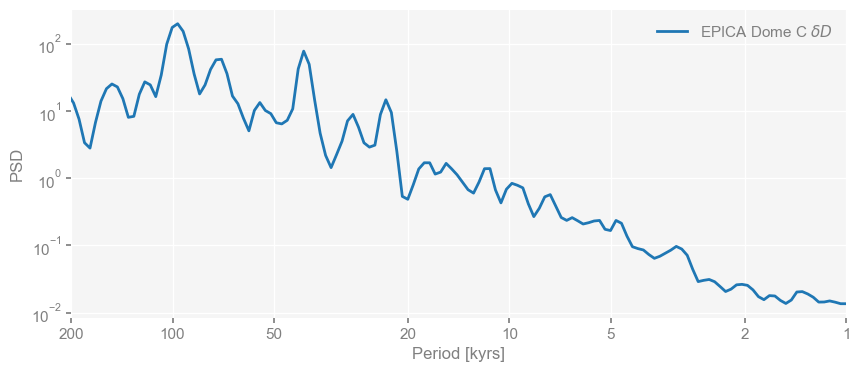

(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot:xlabel='Period [kyrs]', ylabel='PSD'>)

In [10]:
dD05 = dDts.interp(step=0.5).standardize() # save it for future use
psd_wwz = dD05.spectral(method='wwz')
psd_wwz.plot()

Notice how we saved the output of the calculation into a structure called `psd_wwz` before passing that to the plot function; this is to save time, as these calculation can get lengthy. Indeed:

Performing spectral analysis on individual series: 100%|███████████████████████████████████████████████████████████████████| 50/50 [03:46<00:00,  4.53s/it]


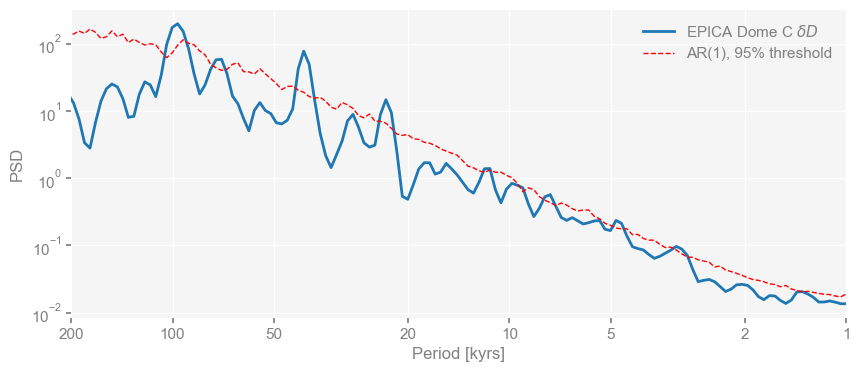

(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot:xlabel='Period [kyrs]', ylabel='PSD'>)

In [11]:
psd_wwz_sig = psd_wwz.signif_test(number=50)
psd_wwz_sig.plot()

The same orbital periods around 20, 40 and 100 kyr pop out, with a few high-frequency bumps grazing the 95% threshold. This may disappear if we ran more AR(1) benchmarks (say, 1000), but running 50 already took some time
(about 3min30s on my machine). You'd certainly want to invest that time for paper/talk, but in this demo we have other fish to fry. 

Let us note in passing that we could plot both of these spectra on the same plot, and add MTM for good measure:

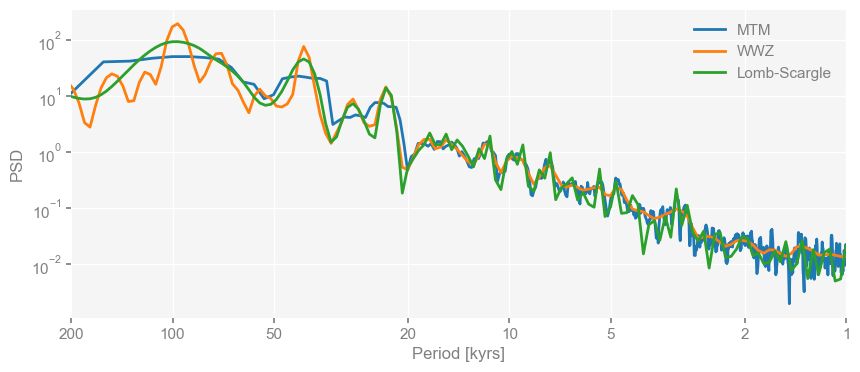

In [12]:
psd_ls  = dD05.spectral(method='lomb_scargle')
psd_mtm = dD05.spectral(method='mtm')
fig, ax = psd_mtm.plot(label='MTM',mute=True)
psd_wwz.plot(ax=ax,label='WWZ',mute=True)
psd_ls.plot(ax=ax,label='Lomb-Scargle')
pyleo.showfig(fig)



 We see that MTM's bias variance tradeoff (with the default time-bandwith product used here) results in very attenuated, broad peaks at orbital periods. WWZ (again with default parameters) results in sharper peaks, with a secondary one around 80ky. Lomb-Scargle is in between those two extremes, and markedly noisier at high frequencies (no matter what is done to its parameters - try it)

## Singular Spectrum Analysis

If we really wanted to focus on orbital periods, we might want to clean the record still further. One way to do this is to apply Singular Spectrum Analysis (SSA) to a standardized, interpolated version of the series (SSA will not work on unevenly spaced data).

In [13]:
dDssa =  dD05.ssa()

The output object, `dDssa`, contains a bunch of usable information, with some associated methods. The first thing that one does with a decomposition like this is to look at the eigenvalue spectrum via a "scree plot": 

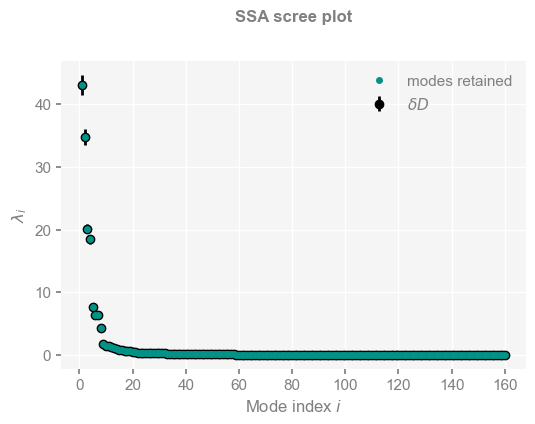

(<Figure size 600x400 with 1 Axes>,
 <AxesSubplot:title={'center':'SSA scree plot'}, xlabel='Mode index $i$', ylabel='$\\lambda_i$'>)

In [14]:
dDssa.screeplot() 

Clearly, the first 8 eigenvalues are a cut above the rest. We should be able to reconstruct most behavior of interest using just those 8. Indeed, if we sum their variance we get to over 99%:

In [15]:
dDssa.pctvar[:7].sum()

99.19409475678574

Let's extract those first 8 modes using `RCmat`, the matrix containing the reconstructed SSA modes, and plot it alongside the original, interpolated data: 

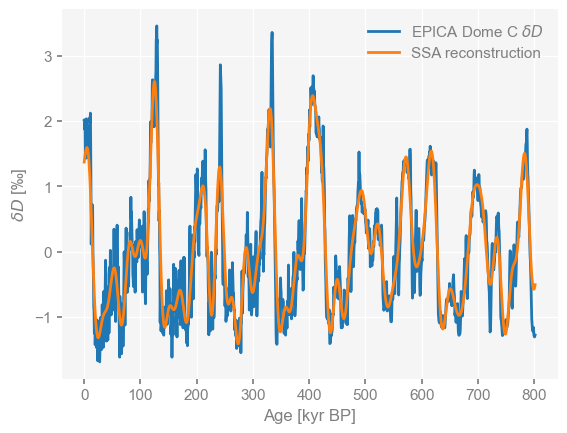

In [16]:
fig, ax = plt.subplots()
dD05.plot(ax=ax, mute=True)
dDrc = dD05.copy()
dDrc.value = dDssa.RCmat[:,:7].sum(axis=1); dDrc.label = 'SSA reconstruction'
dDrc.plot(ax=ax)
pyleo.showfig(fig)

Let's compute its WWZ spectrum and plot it along the old one:

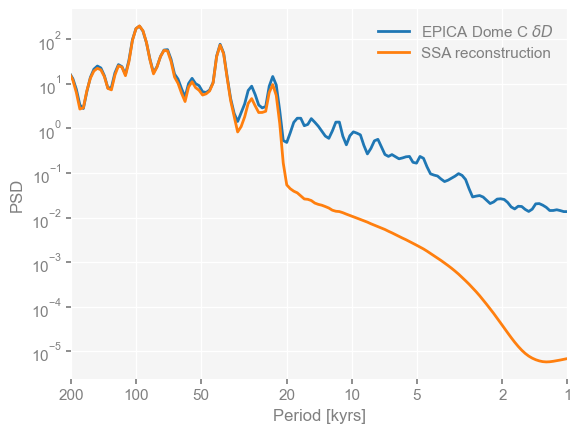

In [17]:
fig, ax = plt.subplots()
psd_wwz.plot(ax=ax,mute=True)
psd_rcwwz = dDrc.spectral(method='wwz')
psd_rcwwz.plot(ax=ax)
pyleo.showfig(fig)

We see that SSA was able to capture the most essential swings of the original series, while filtering out the high frequency noise. In this respect, it acted very much like a lowpass filter, which we could also have applied like so:

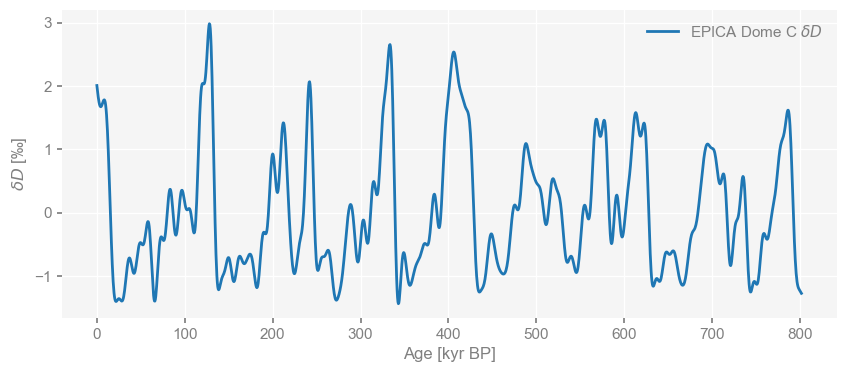

In [18]:
dDlow = dD05.filter(method='lanczos',cutoff_scale=10).plot()

## Wavelet Analysis

Lastly, we play with wavelet analysis, which may be used to "unfold" a spectrum and look at its evolution over time. There are several ways to access that functionality in Pyleoclim, but here we use `summary_plot`, which stacks together the timeseries itself, its scalogram (a plot of the magnitude of the wavelet power), and the power spectral density (PSD) obtained from summing the wavelet coefficients over time. 

Performing wavelet analysis on individual series: 100%|██████████████████████████████████████████████████████████████████| 100/100 [06:56<00:00,  4.16s/it]


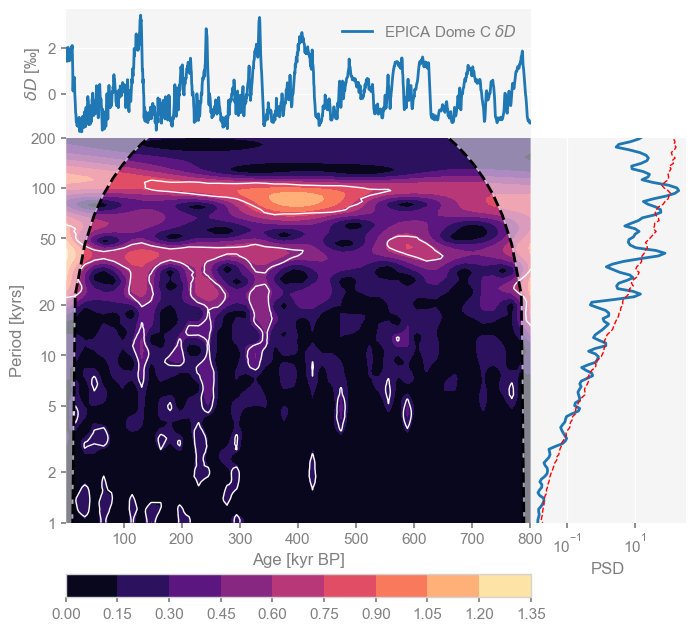

(<Figure size 800x1000 with 4 Axes>,
 {'ts': <AxesSubplot:xlabel='Age [kyr BP]', ylabel='$\\delta D$ [‰]'>,
  'scal': <AxesSubplot:xlabel='Age [kyr BP]', ylabel='Period [kyrs]'>,
  'psd': <AxesSubplot:xlabel='PSD'>})

In [19]:
dD05.summary_plot(psd=psd_wwz_sig,n_signif_test=100)

The scalogram reveals how spectral power (technically, wavelet power) changes over time.  The white lines delineate regions of the scalogram that are significant against an AR(1) benchmark, so encircle "islands" of notable power. We see that the 100kyr periodicity is particularly pronounced around 300-600 kyr BP, while the 40 and 20kyr periodicities are more pronounced in the later portions (since 400 ky BP). This may be because of the compaction of the ice at depth, which you wouldn't know from analyzing just this dataset. Paleoclimate timeseries must always be interpreted with those possible artifacts in mind. 

## Assessing Memory

The last tidbit of fun is to assess the scaling (memory) properties of a timeseries with `Pyleoclim`. To do so, we can fit a regression line to the PSD and estimate its slope, indicative of fundamental scaling laws in the continuum of climate variability. Pyleoclim makes this easy:

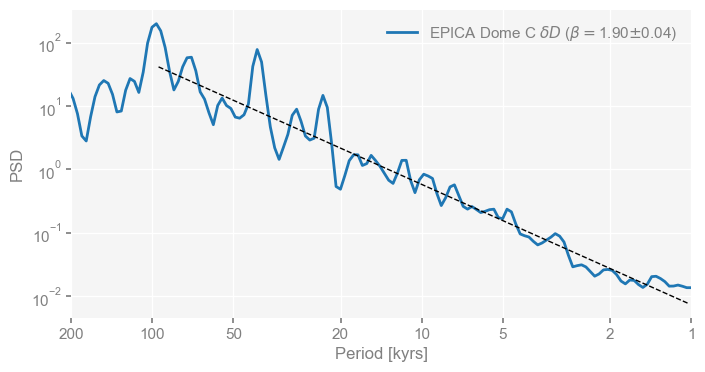

(<Figure size 800x400 with 1 Axes>,
 <AxesSubplot:xlabel='Period [kyrs]', ylabel='PSD'>)

In [29]:
psd_fit = psd_wwz.beta_est(fmin=1/100,fmax=1)
psd_fit.plot(figsize=[8, 4])

Note that this slope is related to the Hurst exponent: $H = \frac{\beta-1}{2}$

In [33]:
beta = psd_fit.beta_est_res['beta'] # extra the scaling exponent
Hurst = (beta-1)/2   # convert to a Hurst exponent
print("The series has a Hurst parameter of " + '{:4.4f}'.format(Hurst))

The series has a Hurst parameter of 0.4492


This value is close to 0.5, the expected value for a Brownian motion type of stochastic process. 

## Temperature and $CO_2$

Now let us load the $CO_2$ composite from this and other neighboring sites around Antarctica:

In [34]:
url = 'ftp://ftp.ncdc.noaa.gov/pub/data/paleo/icecore/antarctica/antarctica2015co2composite.txt'
co2df = pd.read_csv(url,skiprows=137,sep='\t')
co2df.head()

,age_gas_calBP,co2_ppm,co2_1s_ppm
0,-51.03,368.02,0.06
1,-48.00,361.78,0.37
2,-46.28,359.65,0.10
3,-44.41,357.11,0.16
4,-43.08,353.95,0.04


In [35]:
co2ts = pyleo.Series(time=co2df['age_gas_calBP']/1000,value= co2df['co2_ppm'],time_name='Age',time_unit='kyr BP',value_name = r'$CO_2$',value_unit='ppm',label='EPICA Dome C CO2')

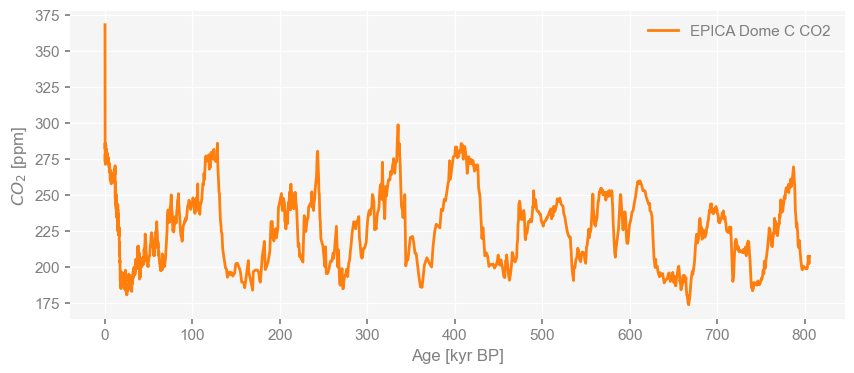

(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot:xlabel='Age [kyr BP]', ylabel='$CO_2$ [ppm]'>)

In [36]:
co2ts.plot(color='C1')

We see very similar Ice Ages as in the deuterium data (that's the point) and of course a precipitous rise since the Industrial Revolution.  To plot the two series side by side, one might do:

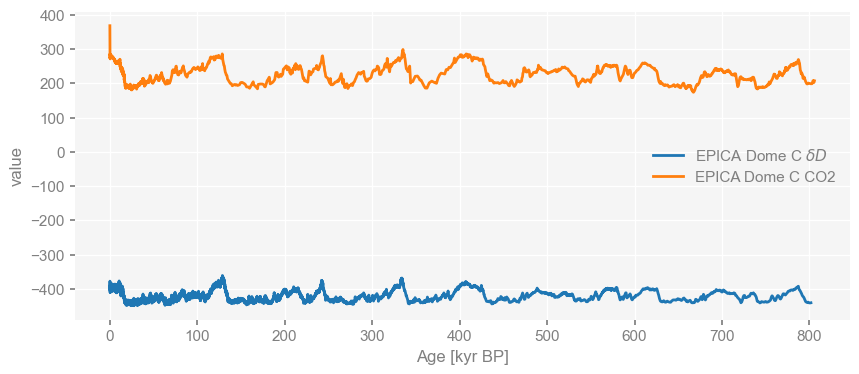

(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot:xlabel='Age [kyr BP]', ylabel='value'>)

In [37]:
ms = pyleo.MultipleSeries([dDts,co2ts])
ms.plot()

By default, the MultipleSeries class assumes commensurate units, which is not really the case here. Fear not, we can just standardize the series:

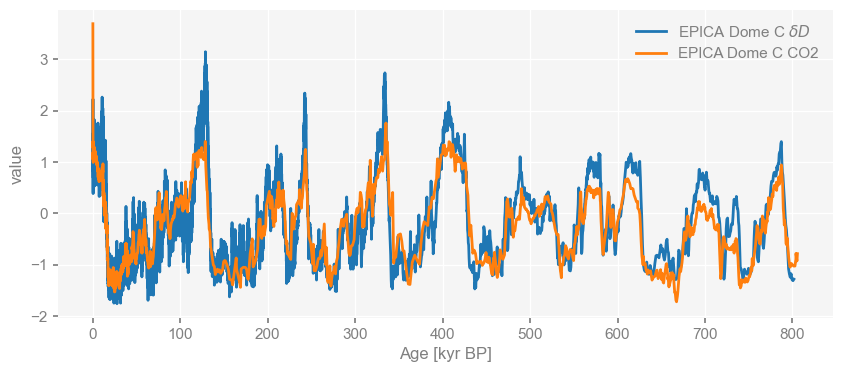

(<Figure size 1000x400 with 1 Axes>,
 <AxesSubplot:xlabel='Age [kyr BP]', ylabel='value'>)

In [38]:
ms.standardize().plot()

We could also plot them as a stack, like so:

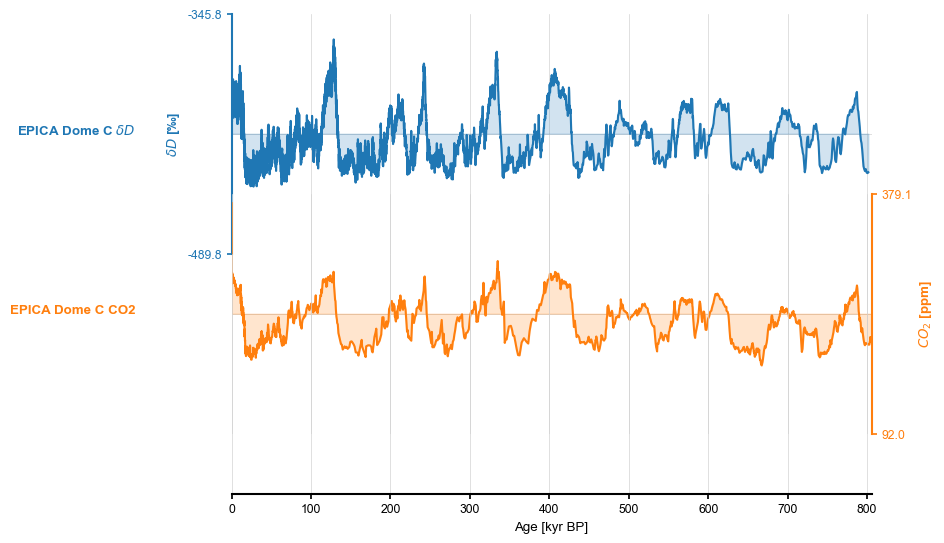

(<Figure size 640x480 with 3 Axes>,
 {0: <Axes:ylabel='$\\delta D$ [‰]'>,
  1: <Axes:ylabel='$CO_2$ [ppm]'>,
  2: <Axes:xlabel='Age [kyr BP]'>})

In [39]:
ms.stackplot()

Now, one might be interested in lead/lag relationships between those two series. Before that, a brief primer: the temperature proxy $\delta D$ is measured on the ice, whereas $CO_2$ is measured in the air trapped in the ice. Because bubbles close only progressively as the firn gets compacted, the air can be younger than the surrouding ice by several hundred years. The ice core community has worked diligently on this for decades and have made very clever adjustments to correct for this effect, but that is to be kept in mind when comparing those two data streams. 

With that in mind, let us apply [wavelet transform coherency](https://hal.archives-ouvertes.fr/hal-00302394/) to identify phase relationships between the two series at various scales:

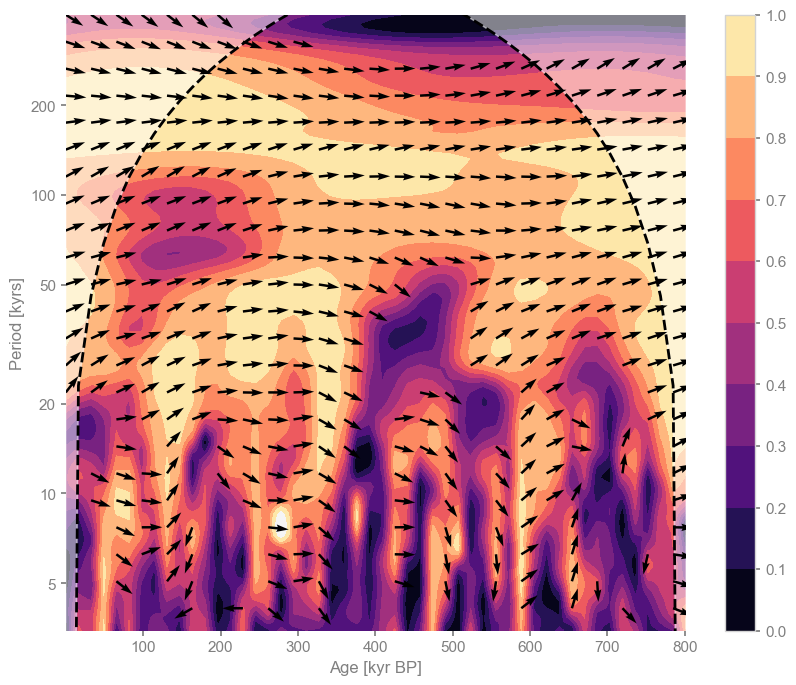

In [42]:
coh = co2ts.wavelet_coherence(dDts,ntau=50)
fig, ax = coh.plot()

Arrows pointing to the right indicate a phase angle close to zero at all scales longer than precession. This means that on orbital timescales, the two series are essentially in phase ; there is no lead or lag between the two series. This is remarkable given the dating challenges mentioned earlier, and is widely interpreted to mean that on such timescales, atmospheric $CO_2$ is a part of a positive feedback loop amplifying orbitally-triggered changes in temperature. In the modern era, of course, atmospheric $CO_2$ is now a forcing (the largest climate forcing, currently), acting on much, much faster timescales for which the climate system is still catching up. 

One might be tempted to interpret phase angles at shorter scales. Let us first see if they are significant against AR(1) benchmarks, As before this can be done in one function call, though some patience is required to obtain the result. 

In [43]:
coh_sig = coh.signif_test(number=100)

Performing wavelet coherence on surrogate pairs: 100%|███████████████████████████████████████████████████████████████████| 100/100 [15:12<00:00,  9.12s/it]


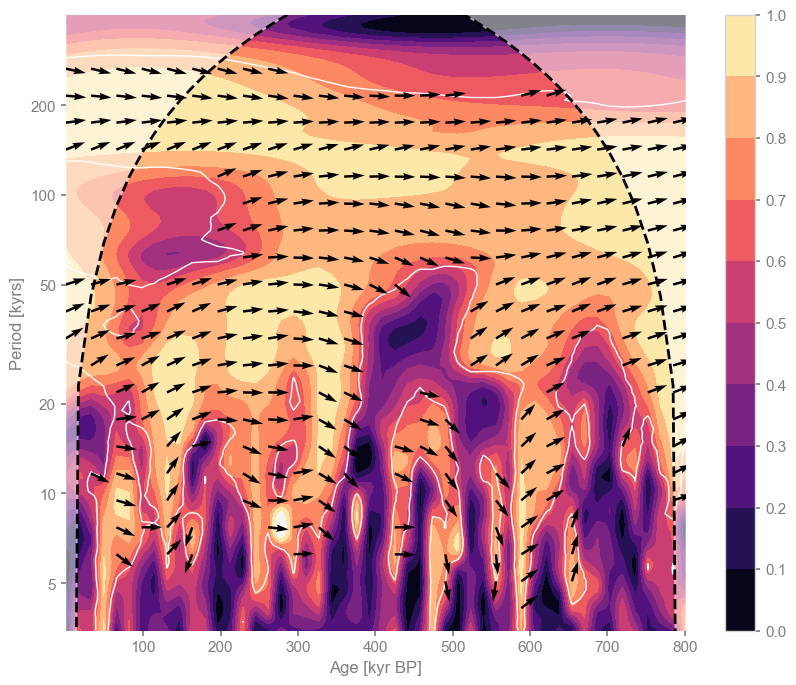

In [44]:
fig, ax = coh_sig.plot()

These phase differences are indeed significant according to this test, but mostly inconsistent (at a given scale, the arrows veer one way or the other). This would not be a good candidates for identifying a robust lead or lag. 

This concludes our mini tour of paleoclimate timeseries wizardry with Pyleoclim. Be sure to check our [documentation](https://pyleoclim-util.readthedocs.io/en/master/) for more! 